In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from neqsim.thermo import TPflash, fluid
from neqsim.thermo.thermoTools import dataFrame, jNeqSim
from smt.sampling_methods import LHS
from typing import Dict

## Referências (NeqSim)

- https://github.com/equinor/neqsim-python
- https://github.com/equinor/neqsim-python/tree/master/examples
- https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=kHt6u-utpvYf

In [2]:
components = {
    "zN2": "nitrogen",
    "zCO2": "CO2",
    "zC1": "methane",
    "zC2": "ethane",
    "zC3": "propane",
    "zIC4": "i-butane",
    "zNC4": "n-butane",
    "zIC5": "i-pentane",
    "zNC5": "n-pentane",
    "zC6": "n-hexane",
    "zC7": "n-heptane",
    "zC8": "n-octane",
    "zC9": "n-nonane",
    "zC10": "nC10",
    "zC11": "nC11",
    "zC12": "nC12",
    "zC13": "nC13",
    "zC14": "nC14",
    "zC15": "nC15",
    "zC16": "nC16",
    "zC17": "nC17",
    "zC18": "nC18",
    "zC19": "nC19",
    "zC20": "nC20",
}

processed_data = pd.read_csv("experimental_data\\processed_data.csv")
composition_data = processed_data.loc[:, processed_data.columns.str.contains("z")]

def set_components(composition: Dict[str, float]):
    fluid1 = fluid("pr")
    for component, fraction in composition.items():
        fluid1.addComponent(components[component], fraction)
    fluid1.setMixingRule("classic")  # classic will use binary kij
    return fluid1

processed_data.head()

,Field,Id,Date,FluidKind,LastFluidMolecularWeight,LastFluidSpecificGravity,zN2,zCO2,zC1,zC2,...,zC12,zC13,zC14,zC15,zC16,zC17,zC18,zC19,zC20,LastFluidComponent
0,Albacora,200588838534569195818022639230611277018,28/11/2013,OLEO,513.0,0.9375,0.28,2.18,50.34,8.80,...,1.39,1.42,1.19,1.12,0.84,0.75,0.74,0.71,7.54,C20
1,Albacora,235655066780487493060135334531738441741,28/11/2013,OLEO,513.0,0.9375,0.28,2.18,50.34,8.80,...,1.39,1.42,1.19,1.12,0.84,0.75,0.74,0.71,7.54,C20
2,Albacora,2850024621782551530469011068396203900,11/12/2014,OLEO,447.0,0.9332,0.36,3.23,45.32,7.16,...,1.35,1.40,1.13,1.07,0.83,0.68,0.74,0.67,10.99,C20
3,Albacora,66820533634321543631617927163864636933,11/12/2014,OLEO,447.0,0.9332,0.36,3.23,45.32,7.16,...,1.35,1.40,1.13,1.07,0.83,0.68,0.74,0.67,10.99,C20
4,Albacora,321567418088616429351396831258924766066,01/08/2007,OLEO,428.0,0.9508,0.01,0.17,42.67,5.08,...,1.44,1.48,1.30,1.30,1.00,0.86,0.84,0.75,24.57,C20


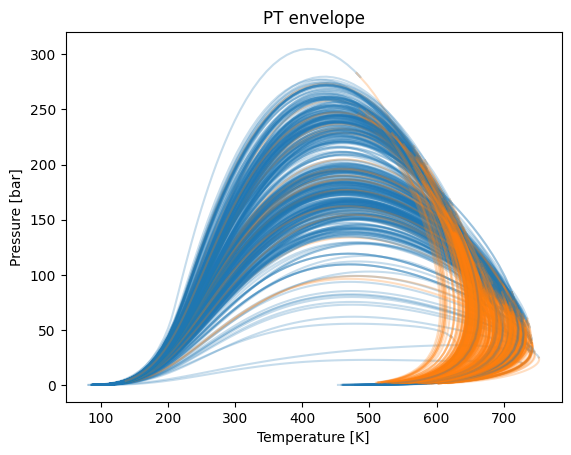

In [3]:
for i in np.arange(processed_data.shape[0]):
    fluid1 = set_components(composition_data.loc[i, :].to_dict())
    thermoOps = jNeqSim.thermodynamicOperations.ThermodynamicOperations(fluid1)
    thermoOps.calcPTphaseEnvelope(True, 0.1)

    if 0.0 in list(thermoOps.getOperation().get("dewT")):
        # print(processed_data.loc[i, :].to_dict())
        thermoOps.calcPTphaseEnvelope(False, 0.1)
        if 0.0 in list(thermoOps.getOperation().get("dewT")):
            composition_data = composition_data.drop(i)
            processed_data = processed_data.drop(i)
            continue

    plt.plot(
        list(thermoOps.getOperation().get("dewT")),
        list(thermoOps.getOperation().get("dewP")),
        label="dew point",
        alpha=0.25,
        color="C0",
    )
    plt.plot(
        list(thermoOps.getOperation().get("bubT")),
        list(thermoOps.getOperation().get("bubP")),
        label="bubble point",
        alpha=0.25,
        color="C1",
    )
plt.title("PT envelope")
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.show()

composition_data = composition_data.reset_index(drop=True)
processed_data = processed_data.reset_index(drop=True)

processed_data.to_csv(
    ".\\experimental_data\\thermodinamically_processed_data.csv",
    index=False,
)

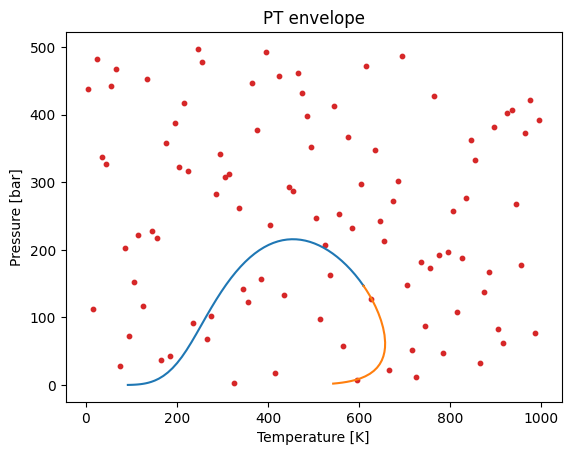

In [4]:
xlimits = np.array([[0.0, 1000.0], [0.0, 500.0]])
sampling = LHS(xlimits=xlimits)

num = 100
TP = sampling(num)

fluid1 = set_components(composition_data.loc[0, :].to_dict())
thermoOps = jNeqSim.thermodynamicOperations.ThermodynamicOperations(fluid1)
thermoOps.calcPTphaseEnvelope(True, 0.1)

plt.plot(
    list(thermoOps.getOperation().get("dewT")),
    list(thermoOps.getOperation().get("dewP")),
    label="dew point",
    color="C0",
)
plt.plot(
    list(thermoOps.getOperation().get("bubT")),
    list(thermoOps.getOperation().get("bubP")),
    label="bubble point",
    color="C1",
)
plt.scatter(TP[:, 0], TP[:, 1], s=10, c="C3")
plt.title("PT envelope")
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.show()

In [19]:
for sample_i in np.arange(TP.shape[0]):
    T, P = TP[sample_i, 0], TP[sample_i, 1]
    fluid1.setTemperature(T)
    fluid1.setPressure(P)

    start = datetime.now()
    TPflash(fluid1)
    # print(f"elapsed time: {datetime.now() - start}")
    print("number of phases:", fluid1.getNumberOfPhases())

    outputs = {}
    components = [c for c in fluid1.getComponentNames()]
    phases = [p for p in fluid1.getPhases() if p]

    print([phase.getPhaseTypeName() for phase in phases])
    if fluid1.getNumberOfPhases() == 2:
        for phase in phases:
            for component in components:
                phase_name = phase.getPhaseTypeName()
                phase_var = ""
                outputs[f"{phase_name}_{component}"] = phase.getComponent(component).getx()

        # print(pd.DataFrame.from_records([outputs]).round(2))
        

number of phases: 1
['oil', 'liquid']
number of phases: 2
['gas', 'oil']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 2
['gas', 'oil']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 2
['gas', 'oil']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 1
['gas', 'liquid']
number of phases: 1
['oil', 'liquid']
number of phases: 2
[

In [20]:
dataFrame(fluid1)

,0,1,2,3,4,5,6
0,,total,GAS,,,,
1,nitrogen,2.8E-3,2.8E-3,,,,[mole fraction]
2,CO2,2.18E-2,2.18E-2,,,,[mole fraction]
3,methane,5.034E-1,5.034E-1,,,,[mole fraction]
4,ethane,8.8E-2,8.8E-2,,,,[mole fraction]
5,propane,5.71E-2,5.71E-2,,,,[mole fraction]
6,i-butane,9.6E-3,9.6E-3,,,,[mole fraction]
7,n-butane,2.47E-2,2.47E-2,,,,[mole fraction]
8,i-pentane,7.5E-3,7.5E-3,,,,[mole fraction]
9,n-pentane,1.25E-2,1.25E-2,,,,[mole fraction]
